# Movie Text Classification of Multi-labeled Genres 
- Given the movie dialog corpus, extract features
- Using the extracted features and accompanying genre labels, build a classifier

## Flowchart of the classifier train and test
- Each flow has a footnote matched with code blocks

![overview](png/overview.png)

## Code and Explanation
- Basically, I commented on the code line and executed them in advance.
- If I need to explain the details, I added a description to the markdown formatted box below each code.

In [1]:
import collections
import nltk
import numpy as np
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import sklearn.metrics as metrics
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn import svm
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import MultiLabelBinarizer
from skmultilearn.problem_transform import BinaryRelevance
from nltk.tokenize import RegexpTokenizer
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
import matplotlib.pyplot as plt
import seaborn as sns

# Some of nltk needs to be downloaded for re-executing in the local setting
# e.g. nltk.download('stopwords')

In [2]:
def load_genres(file_name: str) -> dict:
    """ Load label(genres) from meta file
        
    Parameters:
    file_name (str): input file of meta texts included
    
    Returns:
    movie_genre(dict): key(str) - movie_id, value(set) - a set of movie genre labels
                       e.g. {movie_id:{'comedy', 'romance', ...}, ...}
    
    """
    movie_genres = {}
    with open(file_name, 'r', encoding='utf-8') as f:
        for line in f:
            values = [value.strip() for value in line.split(" +++$+++ ")]
            if len(values) < 6:
                continue
            genres = values[5].strip('][').replace("'", '').split(', ')
            movie_genres[values[0]] = set([g for g in genres if g])
    return movie_genres

"""
sample line of metafile 'data/movie_titles_metadata.txt':
    fields: "movie_id", "title", "year", "score", "rating", "genres"
    m0 +++$+++ 10 things i hate about you +++$+++ 1999 +++$+++ 6.90 +++$+++ 62847 +++$+++ ['comedy', 'romance'] 
"""
movie_genres = load_genres("data/movie_titles_metadata.txt")

print("Sample data of 'movie_genres'")
print("\t> key(movie_id): 'm0'\n\t> value(a set of movie genre labels): " + str(movie_genres['m0']))

Sample data of 'movie_genres'
	> key(movie_id): 'm0'
	> value(a set of movie genre labels): {'romance', 'comedy'}


In [3]:
word_tokenizer = RegexpTokenizer(r'\w+|\$[\d\.]+|\S+')
word_lemmatizer = WordNetLemmatizer()

def process_text(line: str) -> tuple:
    """ Converts a raw text input to parsed patterns
    
    Parameters:
    line (str): a raw text input
    
    Returns:
    raw_words, pos_words, ne_words (tuple): tuple of (word_token, word_token/POS_tag, NE_word/NE_tag)
    
    """
    sentence = line
    tokens = word_tokenizer.tokenize(line)
    pos_tokens = nltk.pos_tag(tokens)
    ne_tokens = nltk.ne_chunk(pos_tokens, binary=False)
    ne_words = []
    for ne_chunk in ne_tokens:
        if type(ne_chunk) == nltk.tree.Tree:
            ne = "_".join([token for token, pos in ne_chunk.leaves()])
            # creates NE_word/NE_tag patterns
            ne_words.append(ne + '/' + ne_chunk.label())
    words_pos = [(word, pos) for word, pos in pos_tokens if word.isalpha()]
    stop_words = set(stopwords.words('english'))
    # creates lower-cased, stopwords removed word_token/POS_tag patterns
    words_pos = [(word, pos) for word, pos in words_pos if not word.lower() in stop_words]
    pos_words = [word_lemmatizer.lemmatize(word) + '/' + pos for word, pos in words_pos]
    # creates lower-cased, lemmatized word_token patterns
    raw_words = str(word_lemmatizer.lemmatize(sentence.lower())).split()
    
    return raw_words, pos_words, ne_words

In [4]:
def load_processed_lines(file_name: str) -> dict:
    """ Load parsed patterns of each movie data to the dict
        
    Parameters:
    file_name (str): input file name
    
    Returns:
    movie_texts(dict): key(str) - movie_id, value(tuple of 3 list) - word_token, word_token/POS_tag, NE_word/NE_tag
                       e.g. {m0:([they, do, not!, they, do, to!, ...], [hope/VBP, okay/VBD, ...], [jenny_kim/PERSON, ...])}
    
    """
    movie_sentences = collections.defaultdict(list)
    movie_texts = {}
    with open(file_name, 'r', encoding='iso-8859-1') as f:
        for line in f:
            values = [value.strip() for value in line.split(" +++$+++ ")]
            if len(values) < 5:
                continue
            movie_sentences[values[2]] += [values[4]]
    for id, text in movie_sentences.items():
        # process raw text to extract patterns using process_text method
        movie_texts[id] = process_text(' '.join(text))
    return movie_texts

"""
sample of raw text file 'data/movie_lines.txt':
    fields: "line_id", "character_id", "movie_id", "character", "text"
    L1045 +++$+++ u0 +++$+++ m0 +++$+++ BIANCA +++$+++ They do not!
"""
movie_texts = load_processed_lines("data/movie_lines.txt")

print("Sample data of 'movie_texts'")
print("\t> key(movie_id): 'm0'\n\t> value(tuple of 3 parsed patterns lists): ", end='')
print("([", end='')
for i in range(5):
    print(str(movie_texts['m0'][0][i]), end=', ')
print("...], [", end='')
for i in range(5):
    print(str(movie_texts['m0'][1][i]), end=', ')
print("...], [", end='')
for i in range(5):
    print(str(movie_texts['m0'][2][i]), end=', ')
print("...])")

Sample data of 'movie_texts'
	> key(movie_id): 'm0'
	> value(tuple of 3 parsed patterns lists): ([they, do, not!, they, do, ...], [hope/VBP, okay/VBD, Let/NNP, go/VB, Wow/NNP, ...], [Wow_Okay/PERSON, Thank_God/PERSON, Guillermo/PERSON, Lesbian/PERSON, Jared_Leto/PERSON, ...])


In [5]:
features_X = []
features_Y = []

def extract_candi_features_from_patterns():
    """ Extracts candidates feature as needed from parsed patterns in movie_texts(dict)
    
    features_X (list of list): extracted candidates feature of each movie
                              e.g. [[lovey_dovey, Jolly/NNP, LG/ORGANIZATION, ...], ...]
    features_Y (list of list): genre labels of each movie
                              e.g. [['romance', 'comedy'], ...]
    
    """
    for movie_id, words in movie_texts.items():
        """ Extracts candidates feature as needed of each movie: bigram, POS, NE
        words[0](n-gram): Extract bigram feature using word_token patterns(It can be used to extract n-gram feature though)
                          e.g. [lovey, dovey, ...] => [lovey_dovey, ...]
        words[1](POS): word_token with Part-Of-Speech tagged patterns
                       e.g. [Jolly/NNP, jolly/JJ, ...]
        words[2](NE): Extract word_token with NE tagged feature
                      e.g. [LG/ORGANIZATION, ...]
        """
        features_X.append(['_'.join(b) for b in nltk.bigrams(words[0])] + 
                         words[1] + words[2])
    for movie_id, genre in movie_genres.items():
        features_Y.append(genre)

extract_candi_features_from_patterns()

print("Size of features_X: " + str(len(features_X)) + "(# of data) * NOT_FIXED(# of candidates features in each movie)\n")
print("Sample data of 'features_X' and 'features_Y'")
print("\t> Size of sample data 'features_X[0]'(m0): 1 * {}(# of candidates features of m0)".format(len(features_X[0])))
print("\t> m0 'feature_Y'(label): " + str(features_Y[0]))
print("\t> m0 'features_X': ", end='')
print("[", end='')
for i in range(10):
    print(str(features_X[0][i]), end=', ')
print("...]")

Size of features_X: 617(# of data) * NOT_FIXED(# of candidates features in each movie)

Sample data of 'features_X' and 'features_Y'
	> Size of sample data 'features_X[0]'(m0): 1 * 7998(# of candidates features of m0)
	> m0 'feature_Y'(label): {'romance', 'comedy'}
	> m0 'features_X': [they_do, do_not!, not!_they, they_do, do_to!, to!_i, i_hope, hope_so., so._she, she_okay?, ...]


In [6]:
# Ratio of Train/Test data set = 9:1
feed_X, feed_X_test, feed_Y, feed_Y_test = train_test_split(features_X, features_Y, 
                                                            test_size=0.1, random_state=43)
print("Number of train data: " + str(len(feed_X)))
print("Number of test data: " + str(len(feed_X_test)))

Number of train data: 555
Number of test data: 62


In [7]:
feature_to_idx = {}
idx_to_feature = {}

def build_feature_dictionary() -> dict:
    """ Build a feature dictionary with train data
        
    feature_to_idx (dict): dictionary of feature(key), index(value)
                                  e.g. {I/NNP:0, LG/ORGANIZATION:1, ...}
    idx_to_feature (dict): dictionary of index(key), feature(value)
                                  e.g. {0:I/NNP, 1:LG/ORGANIZATION, ...}    
    """
    idx = 0
    for sentence_words in feed_X:
        for word in sentence_words:
            if word not in feature_to_idx:
                feature_to_idx[word] = idx
                idx += 1
    return dict([(value, key) for key, value in feature_to_idx.items()])

idx_to_feature = build_feature_dictionary()
feature_size = len(idx_to_feature)
print("Size of feature dictionary: {}".format(feature_size))

Size of feature dictionary: 1098953


## Description of Extracted Features
   - **N-grams**
     - **Bi-gram**: A bi-gram feature is used to give information about the local context or order of words. Because the bi-gram needs to contain the previous word's context in the dialog, I recommend not to remove anything and only converting them to lowercase with lemmatizing. It can be extended to n-gram features to see more context. e.g. lovey_dovey
        - Convert to lowercase letters
        - Lemmatized forms of all words
   - **Part-Of-Speech tags**
     - **Word token with POS**: A word token is a basic way of extracting features from the text which does not care about the order or grammar. It is normally used after pre-processing the text as removing special characters, stopwords(meaningless word set) and lemmatizing them. To let the machine knows the different meaning of watch(wearing) and watch(see), It can be used with Part-Of-Speech tags(e.g. watch/NN, watch/VB).  e.g. Jolly/NNP, jolly/JJ
        - Lemmatized forms of all words
        - Removed special characters and stopwords
        - Part-Of-Speech tagged 
   - **Named Entity(NE) tags**
     - **Named Entity text with 6 NE tags below**: A Named Entities are useful information about proper nouns. With this feature, the machine knows whether the word 'LG' is 'ORGANIZATION' or not.  e.g. LG/ORGANIZATION
        - FACILITY
        - GPE: Geo-Political Entity
        - GSP: Geographical-Social-Political Entity
        - LOCATION
        - ORGANIZATION
        - PERSON      

## Statistics of Features
   - The dimension of the extracted features: 1,098,953
   - Curse of dimensionality: Need to select useful features and reduce feature dimensionality(Feature selection)

In [8]:
def bag_of_feature(feature_map: dict, feed_data: list):
    """ Count feature frequency of each movie
        
    Parameters:
    feature_map (str): A dictionary of features to look-up
    feed_data (dict): listed features of each movie
                      e.g. [[lovey_dovey, Jolly/NNP, LG/ORGANIZATION, ...], ...]
                      
    Returns:
    cnt_array(list of list): counted number of feature appeared in each movie
                             e.g. [[1, 0, 5, ...], ...]
    
    """
    cnt_array = np.zeros((len(feed_data), len(feature_to_idx)))
    for i, v in enumerate(feed_data):
        for word in v:
            if word in feature_map:
                cnt_array[i][feature_map[word]] += 1
    return cnt_array

cnt_X = bag_of_feature(feature_to_idx, feed_X)

print("Sample data of 'cnt_X': " + str(cnt_X[0]) + "\n")
print("Size of 'cnt_X': " + str(len(cnt_X))+ "(# of data) * " + str(len(cnt_X[0])) + "(# of features)")

Sample data of 'cnt_X': [1. 1. 1. ... 0. 0. 0.]

Size of 'cnt_X': 555(# of data) * 1098953(# of features)


In [9]:
genres = ['adventure', 'music', 'action', 'biography',
           'sport', 'thriller', 'short', 'fantasy',
           'war', 'mystery', 'musical', 'animation',
           'adult', 'sci-fi', 'film-noir', 'documentary',
           'horror', 'comedy', 'crime', 'romance',
           'western', 'family', 'history', 'drama']

mlb = MultiLabelBinarizer(classes=genres)
genre_labels = mlb.fit_transform(feed_Y)
"""Converts intuitive format of labels to supported multilabel binary format
   example of genre_lavels:
       ['romance', 'comedy'] => [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0]
"""
binary_labels = [list(i) for i in zip(*genre_labels)]
"""Transpose genre_levels to get all data of index which are belonging to each genre 
"""

print("Size of 'binary_labels': " + str(len(binary_labels)) + " * " + str(len(binary_labels[0])) + "\n")
print("Sample data of 'binary_labels'")
print("\t> The 'adventure' movie data with index set to 1 among all movie data: " + str(binary_labels[0]))

Size of 'binary_labels': 24 * 555

Sample data of 'binary_labels'
	> The 'adventure' movie data with index set to 1 among all movie data: [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

In [10]:
chi_score = []

def multilabel_chi2():
    """ Using a bag of features and binary_labels, calculate the Chi-square score of each feature
    
    chi_score(list of list): calculated Chi-square score of each feature and each genre
                             e.g. [[0.4, 0.3, ...], [0.5, 0.1, ...], ...]
    
    """
    for l in range(len(genre_labels[0])):
        # iterate single chi-square number of labels.
        k_best = SelectKBest(chi2, k='all')
        k_best.fit(cnt_X, binary_labels[l])
        chi_score.append(list(k_best.scores_))

multilabel_chi2()

print("Size of chi_score: " + str(len(chi_score)) + "(# of labels) * " + str(len(chi_score[0])) + "(# of features)\n")
print("Example of chi-square score of each features in 'adventure' genre: [", end='')
for i in range(10):
    print(chi_score[0][i], end=', ')
print("...]")

Size of chi_score: 24(# of labels) * 1098953(# of features)

Example of chi-square score of each features in 'adventure' genre: [2.0915032679738563, 0.20915032679738563, 0.20915032679738563, 0.20915032679738563, 0.6274509803921569, 5.394542597131446, 3.6875656512605044, 2.896030415090013, 2.735337941051262, 0.20915032679738563, ...]


## Feature Selection Using Chi-square statistic

- **Chi-square statistic for multi-label text**
    - One movie data is considered one document.
    - One of class-dependent term(feature) importance measuring methods
    - Single-label Chi-square statistics formula
      (N:document, c: class, t: term(feature)) ![chi_square](png/chi_square.png)
    - Multi-label Chi-square method: Iterates a single chi-square calculation as many as the num of all labels(24) and averages them. It references from [here](http://lpis.csd.auth.gr/publications/spolaor-bioasq.pdf)
    - Known as better than mutual information or information gain methods
    - The dimension of the selected features: 100,034
    - The threshold is decided empirically(using a development set included in the train set)

In [11]:
threshold = 2.5
# get mean of chi_score of each feature and select features which have a higher score than the threshold
selected_features_mean = np.mean(chi_score, axis=0) > threshold
# get feature indexes which are not selected by chi-square score 
false_feature = [i for i, x in enumerate(selected_features_mean) if not x]
# pop all features which are in false_feature
for i in false_feature:
    result = idx_to_feature.pop(i, None)
    feature_to_idx.pop(result, None)

# new feature dictionary with selected features
selected_idx_to_feature = {i: word for i, word in enumerate(idx_to_feature.values())}
selected_feature_to_idx = dict([(value, key) for key, value in selected_idx_to_feature.items()])
print("Size of selected feature: " + str(len(selected_idx_to_feature)))
print("Reduced {} features using the chi-square method\n".format(feature_size - len(selected_idx_to_feature)))

# bag of feature with new selected feature dictionary
cnt_X_train = bag_of_feature(selected_feature_to_idx, feed_X)
cnt_X_test = bag_of_feature(selected_feature_to_idx, feed_X_test)

print("Sample data of 'cnt_X_train': " + str(cnt_X_train[0]))
print("Size of 'cnt_X_train': " + str(len(cnt_X_train))+ "(# of data) * " + str(len(cnt_X_train[0])) + "(# of features)\n")
print("Sample data of 'cnt_X_test': " + str(cnt_X_test[0]))
print("Size of 'cnt_X_test': " + str(len(cnt_X_test))+ "(# of data) * " + str(len(cnt_X_test[0])) + "(# of features)")

Size of selected feature: 100034
Reduced 998919 features using the chi-square method

Sample data of 'cnt_X_train': [ 1.  8. 11. ...  0.  0.  0.]
Size of 'cnt_X_train': 555(# of data) * 100034(# of features)

Sample data of 'cnt_X_test': [0. 0. 2. ... 0. 0. 0.]
Size of 'cnt_X_test': 62(# of data) * 100034(# of features)


In [12]:
tfidf_vec = TfidfTransformer()
# Fit train data to TF-IDF model and transform
tfidf_train = tfidf_vec.fit_transform(cnt_X_train)
# Transform test data using a TF-IDF model fit with train data
tfidf_test = tfidf_vec.transform(cnt_X_test)
X_train = tfidf_train.toarray()
X_test = tfidf_test.toarray()

## Feature Weights

- **TF-IDF(Term Frequency - Inverse Document Frequency)**: 
    - One movie data is considered one document.
    - A high value is measured when words appear intensively in a small number of documents
    - With the selected features, caculate TF-IDF
    - Each document(movie) vectors are normalized with L2 norm while calculating TF-IDF


In [13]:
""" Converts intuitive format of labels in train, test data to supported multilabel binary format
    example of genre_lavels:
       ['romance', 'comedy'] => [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0]
"""
Y_train = mlb.fit_transform(feed_Y)
Y_test = mlb.transform(feed_Y_test)

In [14]:
""" BinaryRelevance trains a classifier per each of the labels
"""
model = BinaryRelevance(svm.SVC(kernel='linear', probability=True),
                        require_dense=[False, True])
model.fit(X_train, Y_train)

BinaryRelevance(classifier=SVC(C=1.0, break_ties=False, cache_size=200,
                               class_weight=None, coef0=0.0,
                               decision_function_shape='ovr', degree=3,
                               gamma='scale', kernel='linear', max_iter=-1,
                               probability=True, random_state=None,
                               shrinking=True, tol=0.001, verbose=False),
                require_dense=[False, True])

## Classifier

- **SVM(Support Vector Machine) for multi-label classify**
    - Feed with scaled weights vector(with TF-IDF)
    - Works well even if the feature dimension is large
    - Binary classification as many as the number of all label(24)
    - Another available try: refine parameters, replace kernel functions

In [15]:
prediction_test = model.predict(X_test)
prediction_train = model.predict(X_train)
    
print("Accuracy of a document-level:\n")
print("Test Loss:", metrics.hamming_loss(Y_test, prediction_test))
print("Test Accuracy:", accuracy_score(prediction_test, Y_test) * 100)

print("Train Loss:", metrics.hamming_loss(Y_train, prediction_train))
print("Train Accuracy:", accuracy_score(prediction_train, Y_train) * 100)

print("\n\nAccuracy of each genre class:\n")
y = [list(i) for i in zip(*Y_test)]
y_hat = [list(i) for i in zip(*prediction_test.toarray())]
label = 0
for i, j in zip(y, y_hat):
    cnt = 0
    for idx in range(len(y[0])):
        if i[idx] == j[idx]:
            cnt += 1
    print(str(genres[label]) + ': ' + str((cnt / len(y[0])) * 100))
    label += 1
    
#from sklearn.metrics import multilabel_confusion_matrix
#print(multilabel_confusion_matrix(Y_test, prediction_test))

Accuracy of a document-level:

Test Loss: 0.09274193548387097
Test Accuracy: 12.903225806451612
Train Loss: 0.01816816816816817
Train Accuracy: 65.04504504504504


Accuracy of each genre class:

adventure: 82.25806451612904
music: 98.38709677419355
action: 75.80645161290323
biography: 93.54838709677419
sport: 98.38709677419355
thriller: 80.64516129032258
short: 100.0
fantasy: 91.93548387096774
war: 95.16129032258065
mystery: 91.93548387096774
musical: 98.38709677419355
animation: 96.7741935483871
adult: 100.0
sci-fi: 83.87096774193549
film-noir: 100.0
documentary: 100.0
horror: 87.09677419354838
comedy: 69.35483870967742
crime: 91.93548387096774
romance: 75.80645161290323
western: 98.38709677419355
family: 98.38709677419355
history: 98.38709677419355
drama: 70.96774193548387


## Train/Test data distribution of each class
![data_split](png/data_split.png)

## Results
  
  - **Expected performance of classifier**
    - When I quantified the labels of each document, there are thousands of label combinations. The combination of 24 labels can be appeared per document = 2<sup>24</sup> = 16,777,216. In this data set, each document has the number of 0 to 8 labels of a total of 24 labels. It seemed like lots of ambiguity is exist(like in case of the relationship of drama, romance, and comedy) even by human-annotating. For those reasons, I expected that the performance will be very low accuracy(20 ~ 30%) with the "Accuracy of a document-level" metric and it was lower than I expected(12.90%).
  - **Evaluation metrics on appropriate purpose**
    - The evaluation depends on the needs: In an example, if the task is the multi-label classification of factors for serious disease, the above "Accuracy of a document-level" evaluation metric is the right method.
    - If the requirements are N-best of labels or some other requirements, the evaluation metric should be fit with the task. The above "Accuracy of each class" shows one of the other evaluation metrics. However, in this task, the data imbalance of each class makes the difficulty to figure out the exact performance with "Accuracy of each class".
    - In the above code block, the commented out code is one of evaluation metrics to show precision and recall using a confusion matrix. However, It calculates binary classification results of each class for the multi-label tasks and this are not enough to analyze the relationship of each label's performance. So, in the next step, I tried to show results deeply with the probability heatmap.
    - When the performance of the test set meets with the appropriate metrics, I evaluate by averaging the K-fold cross-validation.

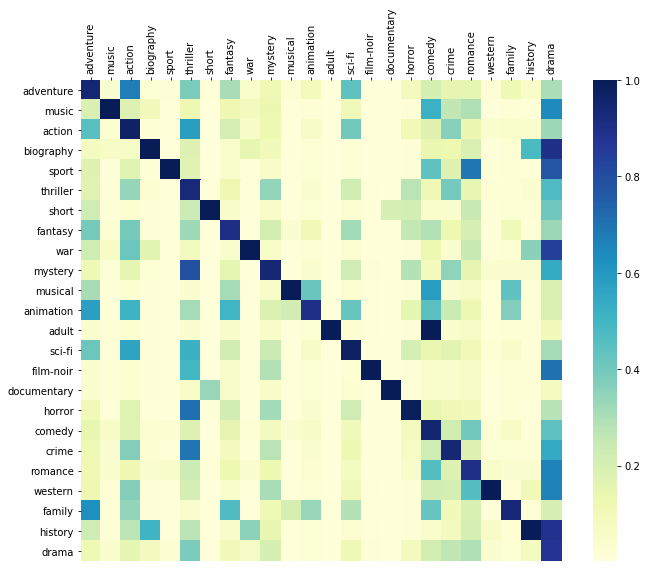

In [16]:
""" Probability distribution of genre labels in each row
"""
prob_train = model.predict_proba(X_train).toarray()
matrix = []
for col in zip(*Y_train):
    idx = [i for i, x in enumerate(col) if x == 1]
    data = []
    for i in idx:
        data.append(prob_train[i])
    matrix.append([sum(x) / len(idx) for x in zip(*data)])
fig, ax = plt.subplots(figsize=(10,8))
ax = sns.heatmap(np.asarray(matrix), yticklabels=genres, cmap="YlGnBu", square=True, ax=ax)
ax.tick_params(top=True, bottom=False, labeltop=True, labelbottom=False)
ax.set_xticklabels(rotation=90, labels=genres)
fig.tight_layout()

## Discussion

  - **Probability distribution heatmap** 
    - Since this task is multi-labeling, the only way to get a confusion matrix is to calculate it from each label's binary classification results. However, this can not show the relationship between each label's results. 
    - What I did above code is to get the SVM output probability of each 24 labels for each sample, normalize it and showed with the heatmap. I <U>sum those 24 output probability for each sample a given label occurs in. Then I divide it by the number of times the label occurred to normalize it</U>. The columns are the labels predicted. The rows will the average of the normalized predictions of the samples which include that label.
    - In this experiment, our test data is too small to see the accurate probability distribution across all classes, I represented it from the result of the train data.
      **e.g.** <U>The row "mystery" will contain the average predictions for each label of all the samples containing the label "mystery"</U>
    - The color from yellow to blue represents the degree of ambiguity on each label.
    - When we see the row "mystery", "horror" and "crime", the "thriller" column fills with a strong blue color. It means that when the system predicts each "mystery", "horror" and "crime" label, It is highly confused with "thriller". 
    - The column "drama" shows that this label has high ambiguity overall with all others. This draws that the 'drama' class has too weak characteristic to be one of the independent class.
      
  - **Most signigicant characteristics**
    - I listed up the features that have high-scored chi-square value and found that the <U>key features have different attributes depending on the most relevant class</U>. As an example, in the <U>'music' class, it seems that proper nouns are important</U>. there are many NE features which are the name of a composer like 'Mozart/PERSON'. It is shown that the uni-gram with POS tagged features revealed a famous place of music like 'Vienna/GSP' or the name of famous people in the music department like Toscanini/NNP. The bi-gram feature captured important compound words like 'berlin_philharmonic'. Also, the <U>'war' class showed similar patterns</U>. In the 'war' class, the examples of key features were the name involved in wars like the 'Adolf/PERSON' and 'Nazi_Party/ORGANIZATION'. <U>Relatively, in the 'romance' or 'drama' genre were represented with bi-gram textual features more</U> extracted from the dialog like 'i_love', 'love_with', etc. Therefore, to fit well for various classes, I think the most import thing is to <U>try various features that have similar or different characteristics and verify them based on the target data</U>. If the one feature is too dominantly control the model, it means that the others are useless. In this case, if the performance is already met we can reduce the dimension of features. otherwise, we need to process feature engineering again for machine learning.


## Future work

- **Propose other sorts of characteristics to maximize the performance**
    - If I have enough data, I would add the <U>dependency parsed features</U>. For the classes which use the bi-gram textual features more from the dialog('romance', 'drama', etc.), it seems that the context of the dialog is important. I would extract pairs of a governor and a dependent from dependency parsed texts. It makes reflect the global contexts to the model from each sentence of a document. Since some classes'('music', 'war', etc.) key features were proper nouns, I would strengthen these features using <U>LDA topic modeling</U> to build topic words of each class. The extracted topic words could be added as features or used as weights for the features.

- **Consider using other parts of the corpus or outside sources to increase performance**
    - I would extract <U>movie titles from the metadata corpus</U>. In most cases, movie titles are represented by text that is closely related to the movie content. It could be used as features itself or used as weights to other text features that have high similarity with title words. 
    - About using the outside sources, I would use <U>contextualized word vectors such as ELMo, BERT or Flair to make a document embedding vector</U>. To be specific, after extracting important sentences within a document, I would make each sentence vector with the contextualized word vectors and a document vector with those sentence vectors. 
    - Also, I could try to use similar but different domain's data which has labels like drama scripts to adapt it to the target model. This is known as <U>transfer learning</U>. 
    - In the aspect of models, I simply try to build an <U>ensemble model</U>. Since some of the classes have ambiguities, I would try hierarchical classifiers that classify by combined classes roughly and separate them by the final targeted number of labels using heuristics or other statistical methods at the next step.